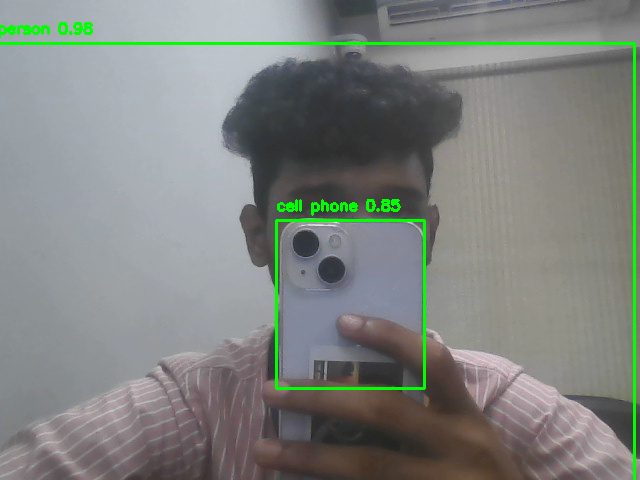

🛑 Detection stopped manually.
✅ Camera released.


In [6]:
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image
import time

# -----------------------------
# Load YOLOv4 model (CPU mode)
# -----------------------------
net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
print("⚙️ Using CPU mode")

# -----------------------------
# Load COCO class labels
# -----------------------------
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

# -----------------------------
# Initialize webcam
# -----------------------------
cap = cv2.VideoCapture(0)  # Change to "video.mp4" for a file

if not cap.isOpened():
    print("❌ Error: Cannot open camera.")
else:
    print("🎥 Camera started. Stop the cell (Kernel > Interrupt) to exit.")

# -----------------------------
# Main loop
# -----------------------------
frame_count = 0
start_time = time.time()

try:
    while True:
        ret, frame = cap.read()
        if not ret or frame is None:
            print("⚠️ Failed to grab frame.")
            break

        height, width, channels = frame.shape

        # Prepare image for YOLOv4
        blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416),
                                     swapRB=True, crop=False)
        net.setInput(blob)
        outputs = net.forward(output_layers)

        boxes, confidences, class_ids = [], [], []

        # Process detections
        for output in outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)

                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        # Non-Max Suppression to remove duplicates
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

        # Draw detections
        if len(indexes) > 0:
            for i in indexes.flatten():
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                confidence = confidences[i]
                color = (0, 255, 0)

                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                cv2.putText(frame, f"{label} {confidence:.2f}",
                            (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, color, 2)

        # Convert to RGB for display in Jupyter
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame_rgb)

        # Display frame inline
        clear_output(wait=True)
        display(img)

        frame_count += 1

except KeyboardInterrupt:
    print("🛑 Detection stopped manually.")

finally:
    cap.release()
    print("✅ Camera released.")
